In [1]:
from __future__ import print_function
from __future__ import division
import os
import cPickle as pickle
import json
import subprocess
from IPython.display import display
from IPython.display import Audio
import bisect
from collections import namedtuple
import numpy as np
import pandas as pd
from collections import Counter
from prettytable import PrettyTable
import matplotlib.pyplot as plt
import seaborn as sns
import textwrap
import nltk
import math
from nltk.corpus import stopwords

from matplotlib.ticker import MultipleLocator, \
     FormatStrFormatter, AutoMinorLocator
%matplotlib inline

In [2]:
with open("config.json") as json_data_file:
    config = json.load(json_data_file)

In [3]:
nodes_fname = config["es"]['nodes_fname']
seg_nodes_fname = config["es"]['seg_nodes_fname']
nodes_dict_fname = config["es"]['nodes_dict_fname']

edges_utd_fname = config["es"]['edges_utd_fname']
edges_olap_fname = config["es"]['edges_olap_fname']
edges_all_fname = config["es"]['edges_all_fname']
edges_score_fname = config["es"]['edges_score_fname']

clusters_utd_fname = config['es']['clusters_utd_fname']
clusters_fname = config['es']['clusters_fname']
clusters_stats_fname = config['es']['clusters_stats_fname']

pairs_fname = config['es']['score_pairs_fname']
eval_fname = config['es']['eval_pairs_fname']

feats_fname = config['es']['feats_fname']

# Gold feats
gold_feats_dict_fname = config['es']['gold_feats']
# Pseudo feats
feats_dict_fname = config['es']['feats_dict_fname']

gold_probs_fname = config['es']['mt_probs_gold']
gold_probs_dict_fname = config['es']['mt_probs_dict_gold']

pseudo_probs_fname = config['es']['mt_probs_pseudo']
pseudo_probs_dict_fname = config['es']['mt_probs_dict_pseudo']

train_segment_list_fname = config['es']['mt_train_files']
dev_segment_list_fname = config['es']['mt_dev_files']

gold_corpus_fname = config['es']['mt_corpus_train_gold']
pseudo_corpus_fname = config['es']['mt_corpus_train_pseudo']

mt_gold_pred_dict_fname = config['es']['mt_gold_pred_dict']
mt_pseudo_pred_dict_fname = config['es']['mt_pseudo_pred_dict']

mt_gold_eval_dict_fname = config['es']['mt_gold_eval_dict']
mt_pseudo_eval_dict_fname = config['es']['mt_pseudo_eval_dict']

es_merge_wavs_path = config['es']['es_merge_wavs']
utd_wavs_path = config['es']['utd_wavs']

utd_tmp_wav_path = config['es']['utd_wavs']

In [4]:
Align = namedtuple('Align', ['word', 'start', 'end'])
Node = namedtuple('Node', ['file', 'seg', 'start', 'end', 'es', 'es_cnt'])
Eval = namedtuple('Eval', ['n1', 'n2', 'dtw', 'es_sim', 'es_cnt_sim', 'en_j_sim'])

In [5]:
segment_map = pickle.load(open(config['es']['segment_dict_fname'], "rb"))
align_dict = pickle.load(open(config['es']['align_dict_fname'], "rb"))
nodes_dict = pickle.load(open(nodes_dict_fname, "rb"))
pairs_list = pickle.load(open(pairs_fname, "rb"))
eval_dict = pickle.load(open(eval_fname, "rb"))
clusters = pickle.load(open(clusters_fname, "rb"))
clusters_stats = pickle.load(open(clusters_stats_fname, "rb"))
feats_dict = pickle.load(open(feats_dict_fname, "rb"))
gold_feats_dict = pickle.load(open(gold_feats_dict_fname, "rb"))

if os.path.exists(gold_probs_dict_fname):
    gold_probs_dict = pickle.load(open(gold_probs_dict_fname, "rb"))

if os.path.exists(pseudo_probs_dict_fname):
    pseudo_probs_dict = pickle.load(open(pseudo_probs_dict_fname, "rb"))

if os.path.exists(mt_gold_pred_dict_fname):
    mt_gold_pred_dict = pickle.load(open(mt_gold_pred_dict_fname, "rb"))
    
if os.path.exists(mt_pseudo_pred_dict_fname):
    mt_pseudo_pred_dict = pickle.load(open(mt_pseudo_pred_dict_fname, "rb"))
    
if os.path.exists(mt_gold_eval_dict_fname):
    mt_gold_eval_dict = pickle.load(open(mt_gold_eval_dict_fname, "rb"))
    
if os.path.exists(mt_pseudo_eval_dict_fname):
    mt_pseudo_eval_dict = pickle.load(open(mt_pseudo_eval_dict_fname, "rb"))    

In [6]:
def gen_node_wav(nid, nodes_dict, utd_wavs_path, src_wavs_path, segment_map):
    pair_wavs_path = os.path.join(utd_wavs_path, "wavs")
    nid_fname = os.path.join(pair_wavs_path, "%d.wav" % nid)
    if not os.path.exists(pair_wavs_path):
        os.makedirs(pair_wavs_path)
    #if os.path.exists(nid_fname):
    #    return
    
    segid = nodes_dict[nid].seg
    fid = (segid.split('.')[0]).strip()
    
    merge_wav_start = segment_map[fid][segid] + nodes_dict[nid].start
    merge_wav_end = segment_map[fid][segid] + nodes_dict[nid].end
    
    merge_wav_fname = os.path.join(src_wavs_path, fid+".wav")
    
    start_time = "{0:0.2f}".format(merge_wav_start/100)
    end_time = "={0:0.2f}".format(merge_wav_end/100)
    subprocess.call(["sox", merge_wav_fname, nid_fname, \
                     "trim", start_time, "{0:s}".format(end_time)])
    
    return Audio(nid_fname)
    
    

In [7]:
display(gen_node_wav(1, nodes_dict, utd_wavs_path, es_merge_wavs_path, segment_map))

In [8]:
def display_pair(pid, eval_dict, nodes_dict, align_dict, utd_wavs_path, src_wavs_path, segment_map):
    headers = ["pair id", "nid", "ES transcript", "EN translation"]
    display_pp = PrettyTable(headers, hrules=True)
    
    n1 = eval_dict[pid].n1
    n2 = eval_dict[pid].n2
    
    en_1 = ' '.join([x.word for x in align_dict[nodes_dict[n1].file][nodes_dict[n1].seg]['en']])
    en_2 = ' '.join([x.word for x in align_dict[nodes_dict[n2].file][nodes_dict[n2].seg]['en']])
    
    row_1 = [pid, n1, ' '.join(nodes_dict[n1].es), textwrap.fill(en_1,50)]
    
    row_2 = [pid, n2, ' '.join(nodes_dict[n2].es), textwrap.fill(en_2,50)]
    
    display_pp.add_row(row_1)
    display_pp.add_row(row_2)
    print(display_pp)
    
    display(gen_node_wav(n1, nodes_dict, utd_wavs_path, es_merge_wavs_path, segment_map))
    display(gen_node_wav(n2, nodes_dict, utd_wavs_path, es_merge_wavs_path, segment_map))
    #print(display_pp.get_html_string())

    

In [9]:
display_pair(16210, eval_dict, nodes_dict, align_dict, utd_wavs_path, es_merge_wavs_path, segment_map)

+---------+-------+----------------+----------------------------------------------------+
| pair id |  nid  | ES transcript  |                   EN translation                   |
+---------+-------+----------------+----------------------------------------------------+
|  16210  | 14185 |  CUIDADO PERO  |  NO NO IT IS NO SO SERIOUS BUT SHE HAS THAT THAT   |
|         |       |                | WORRY WHO KNOWS MAYBE IS JUST MASS SOMETHING IS A  |
|         |       |                |                  LITTLE BALL THAT                  |
+---------+-------+----------------+----------------------------------------------------+
|  16210  | 14186 | LLAMAROS Y QUE | WELL SHE SAID THAT SHE SHE WAS GOING TO CALL SO I  |
|         |       |                | SHE HAD LEFT PHONE NUMBER BECAUSE SHE WAS SLEEPING |
|         |       |                | IT NOW TWO TIMES THAT HAS CALLED AND SHE 'S ASLEEP |
|         |       |                |                SO SHE CAN 'T ANSWER                |
+---------

## Pseudotext analysis

In [10]:
train_segment_list_fname, dev_segment_list_fname

(u'../files-train-calls-63-120-10.txt', u'../files-dev-calls-63-120-10.txt')

In [11]:
train_fids = []
train_sids = []
with open(train_segment_list_fname, "r") as in_f:
    for line in in_f:
        train_fids.append(line.strip().split(".")[0])
        train_sids.append(line.strip())
train_fids = set(train_fids)
train_sids = set(train_sids)

In [12]:
dev_fids = []
dev_sids = []
with open(dev_segment_list_fname, "r") as in_f:
    for line in in_f:
        dev_fids.append(line.strip().split(".")[0])
        dev_sids.append(line.strip())
dev_fids = set(dev_fids)
dev_sids = set(dev_sids)

In [13]:
clusters_stats['is_dev'] = []
clusters_stats['is_train'] = []
clusters_stats['oov'] = []
clusters_stats['cross_seg'] = []
clusters_stats['cross_file'] = []
clusters_stats['same_seg'] = []
clusters_stats['in_vocab'] = []
for sids in clusters_stats['sids']:
    is_in_dev = len(dev_sids & set(sids)) > 0
    is_in_train = len(train_sids & set(sids)) > 0
    clusters_stats['is_dev'].append(is_in_dev)
    clusters_stats['is_train'].append(is_in_train)
    clusters_stats['oov'].append(is_in_dev and not is_in_train)
    clusters_stats['in_vocab'].append(is_in_dev and is_in_train)
    cross_seg = False
    cross_file = False
    same_seg = False
    if is_in_dev and is_in_train:
        common_sids = (dev_sids & set(sids)) | (train_sids & set(sids))
        cross_seg = (len(common_sids) > 1)
        cross_file = (len(set([s.split('.')[0] for s in common_sids])) > 1)
        
    if is_in_dev or is_in_train:
        same_seg = (len(set(sids)) == 1)
        
    clusters_stats['cross_seg'].append(cross_seg)
    clusters_stats['cross_file'].append(cross_file)
    clusters_stats['same_seg'].append(same_seg)
        
        

clusters_stats['dev_depth'] = []
clusters_stats['train_depth'] = []
for nlist in clusters_stats['sids']:
    clusters_stats['dev_depth'].append(len([i for i in nlist if i in dev_sids]))
    clusters_stats['train_depth'].append(len([i for i in nlist if i in train_sids]))


In [14]:
num_oov = sum([i for i in clusters_stats['oov']])
print(num_oov)
sum_oov = sum([d for i, d in enumerate(clusters_stats['dev_depth']) if clusters_stats['oov'][i]])
total_pwords = sum([d for i, d in enumerate(clusters_stats['dev_depth']) if clusters_stats['is_dev'][i]])
print(sum_oov)
print(total_pwords)

697
892
1516


In [15]:
def mini_print(out_cols, out_rows):
    out_line = PrettyTable(out_cols)
    print(" & ".join(out_cols))
    if type(out_rows[0]) == list:
        for row in out_rows:
            out_line.add_row(row)
            print(" & ".join(map(str, row)))
    else:
        out_line.add_row(out_rows)
        print(" & ".join(map(str, out_rows)))
    print(out_line)

In [16]:
def oov_summary(dev_sids, feats_dict):
    dev_words = []
    train_words = []
    oov_pwords = []
    for did in dev_sids:
        dev_words.extend([w.decode('utf-8') for w in feats_dict[did]])
    for tid in train_sids:
        train_words.extend([w.decode('utf-8') for w in feats_dict[tid]])
    set_train_words = set(train_words)
    oov_words = [cid for cid in dev_words if cid not in set_train_words and cid != "-1"]
    missing_train_words = [cid for cid in train_words if cid == "-1"]
    missing_words = [cid for cid in dev_words if cid == "-1"]
    out_cols = ["train words", "dev words", "oov", "oov types", "miss.", "oov + miss.", "vocab", "oov vocab"]
    out_rows = [len(train_words), len(dev_words), len(oov_words), len(set(oov_words)), \
                len(missing_words), len(oov_words) + len(missing_words), len(set(dev_words)), len(set(oov_words))]
    mini_print(out_cols, out_rows)
    return Counter(train_words), Counter(dev_words), Counter(oov_words)

In [17]:
train_pwords, dev_pwords, oov_pwords = oov_summary(dev_sids, feats_dict)
train_gold_words, dev_gold_words, oov_gold_words = oov_summary(dev_sids, gold_feats_dict)

train words & dev words & oov & oov types & miss. & oov + miss. & vocab & oov vocab
20944 & 2029 & 892 & 697 & 513 & 1405 & 1265 & 697
+-------------+-----------+-----+-----------+-------+-------------+-------+-----------+
| train words | dev words | oov | oov types | miss. | oov + miss. | vocab | oov vocab |
+-------------+-----------+-----+-----------+-------+-------------+-------+-----------+
|    20944    |    2029   | 892 |    697    |  513  |     1405    |  1265 |    697    |
+-------------+-----------+-----+-----------+-------+-------------+-------+-----------+
train words & dev words & oov & oov types & miss. & oov + miss. & vocab & oov vocab
37985 & 4129 & 719 & 526 & 0 & 719 & 1561 & 526
+-------------+-----------+-----+-----------+-------+-------------+-------+-----------+
| train words | dev words | oov | oov types | miss. | oov + miss. | vocab | oov vocab |
+-------------+-----------+-----+-----------+-------+-------------+-------+-----------+
|    37985    |    4129   | 7

In [18]:
train_pwords_es = Counter([clusters_stats['most_common'][int(cid)].upper() for cid in train_pwords if cid != -1])
dev_pwords_es = Counter([clusters_stats['most_common'][int(cid)].upper() for cid in dev_pwords if cid != -1])
oov_pwords_es = Counter([clusters_stats['most_common'][int(cid)].upper() for cid in oov_pwords if cid != -1])

In [19]:
out_cols = ["train/dev/oov", "total", "types"]
out_rows = []
out_rows.append(['train', sum(train_pwords_es.values()), len(train_pwords_es)])
out_rows.append(['dev', sum(dev_pwords_es.values()), len(dev_pwords_es)])
out_rows.append(['oov', sum(oov_pwords_es.values()), len(oov_pwords_es)])
mini_print(out_cols, out_rows)

train/dev/oov & total & types
train & 10203 & 2719
dev & 1265 & 664
oov & 697 & 413
+---------------+-------+-------+
| train/dev/oov | total | types |
+---------------+-------+-------+
|     train     | 10203 |  2719 |
|      dev      |  1265 |  664  |
|      oov      |  697  |  413  |
+---------------+-------+-------+


In [20]:
inv_words = [cid for cid in set(dev_pwords) - set(oov_pwords)]
print("dev pwords in train vocab: %d" % len(inv_words))
missing_translations = [cid for cid in inv_words if cid not in pseudo_probs_dict]
print("translations missing for: %d" %len(missing_translations))

dev pwords in train vocab: 568
translations missing for: 1


In [21]:
def recall_summary(eval_dict, dev_sids, feats_dict, oov_words, k):
    k = 10
    num_en_oov = sum([eval_dict['dev'][k][sid]['t'] for sid in set(dev_sids) \
                      if len(set(feats_dict[sid])-set(oov_words)) == 0])
    num_inv_and_oov = sum([1 for sid in set(dev_sids) if len(set(feats_dict[sid])-set(oov_words)) > 0])
    num_only_oov = sum([1 for sid in set(dev_sids) if len(set(feats_dict[sid])-set(oov_words)) == 0])
    num_en = sum([eval_dict['dev'][k][sid]['t'] for sid in set(dev_sids)])
    num_en_missing = sum([eval_dict['dev'][k][sid]['t'] for sid in set(dev_sids) \
                      if feats_dict[sid] == ['-1']])

    num_en_pred = sum([eval_dict['dev'][k][sid]['tp'] for sid in set(dev_sids)])
    num_en_corr_pred = sum([eval_dict['dev'][k][sid]['cp'] for sid in set(dev_sids)])

    out_cols = ["total en", "en oov", "en missing", "upper bound recall"]
    out_rows = [num_en, num_en_oov, num_en_missing, "{0:.3f}".format((num_en-num_en_oov-num_en_missing)/num_en)]

    mini_print(out_cols, out_rows)

    out_cols = ["k", "\\# corr.", "\\# pred", "prec.", "rec.", "rec. w/o miss.", "rec. w/o oov", "rec. w/o miss.+oov"]
    out_rows = map(lambda v: "{0:.2f} \%".format(v*100) if type(v) != int else v, \
                   [k, num_en_corr_pred, num_en_pred, (num_en_corr_pred/num_en_pred), (num_en_corr_pred/num_en), num_en_corr_pred/(num_en-num_en_missing), \
                    num_en_corr_pred/(num_en-num_en_oov), num_en_corr_pred/(num_en-num_en_missing-num_en_oov)])
    mini_print(out_cols, out_rows)
    mini_print(['inv+oov', 'only oov'], [num_inv_and_oov, num_only_oov])

In [22]:
k=10
recall_summary(mt_pseudo_eval_dict, dev_sids, feats_dict, oov_pwords, k)

total en & en oov & en missing & upper bound recall
4290 & 765 & 1545 & 0.462
+----------+--------+------------+--------------------+
| total en | en oov | en missing | upper bound recall |
+----------+--------+------------+--------------------+
|   4290   |  765   |    1545    |       0.462        |
+----------+--------+------------+--------------------+
k & \# corr. & \# pred & prec. & rec. & rec. w/o miss. & rec. w/o oov & rec. w/o miss.+oov
10 & 90 & 3504 & 2.57 \% & 2.10 \% & 3.28 \% & 2.55 \% & 4.55 \%
+----+----------+---------+---------+---------+----------------+--------------+--------------------+
| k  | \# corr. | \# pred |  prec.  |   rec.  | rec. w/o miss. | rec. w/o oov | rec. w/o miss.+oov |
+----+----------+---------+---------+---------+----------------+--------------+--------------------+
| 10 |    90    |   3504  | 2.57 \% | 2.10 \% |    3.28 \%     |   2.55 \%    |      4.55 \%       |
+----+----------+---------+---------+---------+----------------+--------------+---

In [23]:
recall_summary(mt_gold_eval_dict, dev_sids, gold_feats_dict, oov_gold_words, k)
'''
The impact of oov words is less in the case of gold features, 
as other words in the utterances still make predictions. 

However, due to the sparse nature of pseudotext, generally there are no in vocab words for the utterance when
oov words are encountered
'''

total en & en oov & en missing & upper bound recall
4290 & 52 & 0 & 0.988
+----------+--------+------------+--------------------+
| total en | en oov | en missing | upper bound recall |
+----------+--------+------------+--------------------+
|   4290   |   52   |     0      |       0.988        |
+----------+--------+------------+--------------------+
k & \# corr. & \# pred & prec. & rec. & rec. w/o miss. & rec. w/o oov & rec. w/o miss.+oov
10 & 2224 & 11845 & 18.78 \% & 51.84 \% & 51.84 \% & 52.48 \% & 52.48 \%
+----+----------+---------+----------+----------+----------------+--------------+--------------------+
| k  | \# corr. | \# pred |  prec.   |   rec.   | rec. w/o miss. | rec. w/o oov | rec. w/o miss.+oov |
+----+----------+---------+----------+----------+----------------+--------------+--------------------+
| 10 |   2224   |  11845  | 18.78 \% | 51.84 \% |    51.84 \%    |   52.48 \%   |      52.48 \%      |
+----+----------+---------+----------+----------+----------------+----

'\nThe impact of oov words is less in the case of gold features, \nas other words in the utterances still make predictions. \n\nHowever, due to the sparse nature of pseudotext, generally there are no in vocab words for the utterance when\noov words are encountered\n'

In [24]:
mini_print(["train fids", "dev fids", "train sids", "dev sids"], \
          [len(train_fids), len(dev_fids), len(train_sids), len(dev_sids)])

train fids & dev fids & train sids & dev sids
45 & 5 & 8055 & 911
+------------+----------+------------+----------+
| train fids | dev fids | train sids | dev sids |
+------------+----------+------------+----------+
|     45     |    5     |    8055    |   911    |
+------------+----------+------------+----------+


In [25]:
def show_common(counter_A, counter_B):
    set_A = set(counter_A.keys())
    set_B = set(counter_B.keys())
    common = set_A & set_B
    return common, len(common)

In [26]:
_, k = show_common(oov_pwords_es, oov_gold_words)
print(k)
_, k = show_common(train_pwords_es, train_gold_words)
print(k, len(train_pwords_es), len(train_gold_words))

55
1870 2719 6511


In [27]:
def get_dur_for_sids(sids, align_dict):
    dur = 0
    for sid in sids:
        dur += sum([word.end-word.start for word in align_dict[sid.split('.')[0]][sid]['es']])
    return dur / (100 * 3600)

In [28]:
# train sids duration
train_sid_dur = "%.3f" % get_dur_for_sids(train_sids, align_dict)
dev_sid_dur = "%.3f" % get_dur_for_sids(dev_sids, align_dict)
mini_print(["train sid dur", "dev sid dur"], [train_sid_dur, dev_sid_dur])

train sid dur & dev sid dur
6.035 & 0.659
+---------------+-------------+
| train sid dur | dev sid dur |
+---------------+-------------+
|     6.035     |    0.659    |
+---------------+-------------+


### pseudowords

## Cluster Analysis

In [29]:
def plot_word_freq(count_dict, num=10, fig_name = '', prefix='', color='salmon'):
    if prefix:
        count_dict = {"%s_%s" % (prefix, k): v for k,v in count_dict.items()}
    pd_es_df = pd.DataFrame(sorted(count_dict.items(), reverse=True, key=lambda t:t[1])[:num], index=range(num))
    pd_es_df.columns = ["word", "freq"]
    fig, ax = plt.subplots(figsize=(10,5))
    sns.barplot(y='word', x="freq", data=pd_es_df, label=fig_name, color=color)
    ax.legend(ncol=1, loc="center right", frameon=True, fontsize=20)

    #ax.set(xlim=(0, 300))

    plt.xlabel("word counts", size=20)
    plt.ylabel("word types", size=20)

    plt.yticks(rotation=0, size=18)
    plt.xticks(rotation=0, size=18)

    sns.despine(left=True, bottom=True)

    fig.tight_layout()
    

In [30]:
def get_en_words(align_dict, seg_id, en_key):
    en_words = [w.word for w in align_dict[seg_id.split('.')[0]][seg_id][en_key] if "'" not in w.word]
    if not en_words:
        en_words = [w.word for w in align_dict[seg_id.split('.')[0]][seg_id]['en'] if "'" not in w.word]
    return en_words

In [31]:
def get_word_counts(w_key, feats_dict, align_dict, sids):
    if w_key.startswith('es'):
        wrds = [a.decode("utf-8") for sid in feats_dict for a in feats_dict[sid] if sid in sids]
    else:
        wrds = [a for sid in sids for a in get_en_words(align_dict, sid, w_key)]
    return Counter(wrds)

In [32]:
def calc_avg_purity(clusters_df):
    num = sum(clusters_df.apply(lambda row: \
                            Counter(row.words).most_common(1)[0][1] \
                            if len(row.words) > 0 else 0, axis=1))
    den = sum(clusters_df.apply(lambda row: len(row.words), axis=1))
    return (num / den)

In [33]:
def play_cluster(cid):
    cid_wav_path = os.path.join(config["es"]["zrt_tmp_wav"], "%04d.wav" %(cid+1))
    return Audio(cid_wav_path)

In [34]:
def show_translation_prob(wid, probs_dict):
    if wid.upper() not in probs_dict:
        print("%s not found in tm model" %wid)
        return
    print("translation probability table for %s" %wid)
    cols = ['en word', 'prob']
    rows = []
    prob_sum = sum([math.exp(prob) for prob in probs_dict[wid.upper()].values()])
    
    print("prob sum: %.4f" % prob_sum)
    
    for enw, prob in probs_dict[wid.upper()].items():
        rows.append([enw.lower(), "%.4f" % (math.exp(prob) / prob_sum)])
    mini_print(cols, rows)

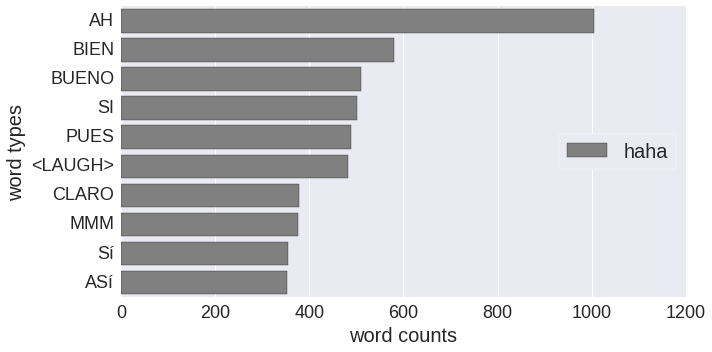

In [35]:
plot_word_freq(train_gold_words, fig_name="haha", color='grey')

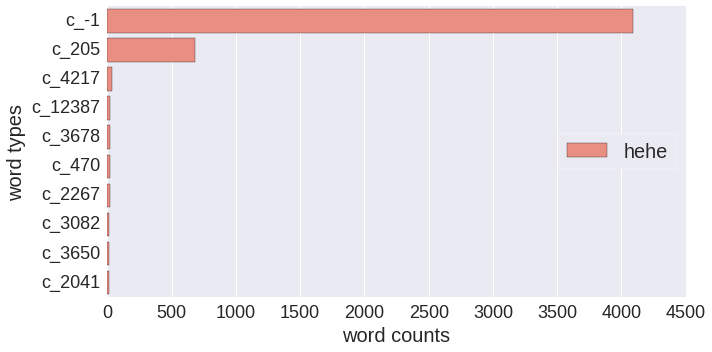

In [37]:
plot_word_freq(train_pwords, fig_name="hehe", prefix='c', color="salmon")

In [38]:
eval_df = pd.DataFrame(eval_dict, columns=Eval._fields)
clusters_df = pd.DataFrame(clusters_stats)
del clusters_df['avg_purity']
clusters_df['depth'] = clusters_df.apply(lambda row: len(row['words']), axis=1)

In [39]:
print(len(clusters_df[clusters_df['same_seg']== True]), len(clusters_df))

267 15089


In [40]:
print(len(clusters_df[clusters_df['cross_seg']== True]), len(clusters_df))

567 15089


In [41]:
print(len(clusters_df[clusters_df['cross_file']== True]), len(clusters_df))

567 15089


In [42]:
cross_seg_cids = {s for s, c in enumerate(clusters_stats['cross_seg']) if c == True}

In [43]:
cross_file_cids = {s for s, c in enumerate(clusters_stats['cross_file']) if c == True}

In [44]:
print(len(set(train_pwords) & set(dev_pwords)))
hmm = {int(i) for i in set(train_pwords) & set(dev_pwords)}

568


### View clusters

In [45]:
view_cols = ['most_common', 'oov', 'purity', 'words', 'depth', 'cross_seg', 'cross_file']

In [46]:
def sid_to_cid_mapping(clusters_stats):
    sid_to_cids = {}
    for cid, sids in enumerate(clusters_stats['sids']):
        for sid in sids:
            if sid not in sid_to_cids:
                sid_to_cids[sid] = set()
            sid_to_cids[sid] |= {cid}
    return sid_to_cids
            

In [47]:
sid_to_cids = sid_to_cid_mapping(clusters_stats)

In [48]:
def get_cids_for_sid(sid, clusters_stats):
    sid_cids = [cid for cid, sids in enumerate(clusters_stats["sids"]) if sid in sids]
    return sid_cids

In [49]:
def find_sids_with_common_pwords(clusters_stats, filter_sids, sid_to_cids):
    check_sids = list(filter_sids)
    sid_overlap = []
    for i in range(len(check_sids)):
        if i % 1000 == 0:
            print("at %d out of %d ... " %(i, len(check_sids)) )
        for j in range(i+1, len(check_sids)):
            if check_sids[i] in sid_to_cids and check_sids[j] in sid_to_cids:
                t1 = sid_to_cids[check_sids[i]]
                t2 = sid_to_cids[check_sids[j]]
                if len(t1 & t2) > 0:
                    sid_overlap.append((check_sids[i], check_sids[j], len(t1 & t2), t1&t2))
    return sid_overlap

In [50]:
def find_cids_with_common_sids(clusters_stats, filter_sids):
    cid_overlap = []
    for i in range(len(clusters_stats['sids'])):
        if i % 1000 == 0:
            print("at %d out of %d ... " %(i, len(clusters_stats['sids'])) )
        for j in range(i+1, len(clusters_stats['sids'])):
            t1 = set(clusters_stats['sids'][i]) & filter_sids
            t2 = set(clusters_stats['sids'][j]) & filter_sids
            if len(t1 & t2) > 0:
                cid_overlap.append((i, j, len(t1 & t2), t1&t2))
    return cid_overlap

In [51]:
sid_overlap = find_sids_with_common_pwords(clusters_stats, train_sids, sid_to_cids)

at 0 out of 8055 ... 
at 1000 out of 8055 ... 
at 2000 out of 8055 ... 
at 3000 out of 8055 ... 
at 4000 out of 8055 ... 
at 5000 out of 8055 ... 
at 6000 out of 8055 ... 
at 7000 out of 8055 ... 
at 8000 out of 8055 ... 


In [52]:
cid_overlap = find_cids_with_common_sids(clusters_stats, train_sids)

at 0 out of 15089 ... 
at 1000 out of 15089 ... 
at 2000 out of 15089 ... 
at 3000 out of 15089 ... 
at 4000 out of 15089 ... 
at 5000 out of 15089 ... 
at 6000 out of 15089 ... 
at 7000 out of 15089 ... 
at 8000 out of 15089 ... 
at 9000 out of 15089 ... 
at 10000 out of 15089 ... 
at 11000 out of 15089 ... 
at 12000 out of 15089 ... 
at 13000 out of 15089 ... 
at 14000 out of 15089 ... 
at 15000 out of 15089 ... 


In [53]:
corr = [3, 5, 7]
pred = [5, 10, 15]
gold = [10, 10, 10]
for i in range(3):
    print("%.2f" % (corr[i]/gold[i]), end=" & ")
#     print(corr[i]/pred[i])

0.30 & 0.50 & 0.70 & 

In [54]:
(eval_df.sort_values('dtw', ascending=False, inplace=False)).head(5)

,n1,n2,dtw,es_sim,es_cnt_sim,en_j_sim
4361,13465,13466,0.999,1,1,1.000000
2869,18715,18716,0.999,1,1,0.250000
12798,12919,12920,0.999,1,1,0.222222
4709,55845,55846,0.999,1,1,0.200000
9457,9885,9886,0.999,1,1,0.142857


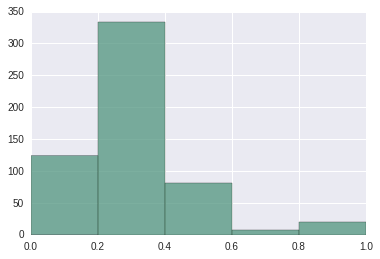

In [55]:
# clusters_df['purity'].hist()
clusters_df.purity[clusters_df.cross_seg == True].hist(alpha=0.5, bins=5)
clusters_df.purity[clusters_df.cross_file == True].hist(alpha=0.5, bins=5)

In [56]:
calc_avg_purity(clusters_df)

0.339489235964542

In [57]:
calc_avg_purity(clusters_df[clusters_df.same_seg])

0.59246171967020023

In [58]:
len(clusters_df[(clusters_df.cross_seg ==  True) & (clusters_df.cross_file == True)])

567

In [62]:
# calc_avg_purity(clusters_df[(clusters_df.cross_seg == True) & (clusters_df.cross_file == False)])

In [63]:
calc_avg_purity(clusters_df[clusters_df.cross_file])

0.1437908496732026

In [64]:
calc_avg_purity(clusters_df[clusters_df.is_dev]), calc_avg_purity(clusters_df[clusters_df.is_train])

(0.20904755767495811, 0.31689036935436465)

In [65]:
len(clusters_df[clusters_df.cross_file]), len(clusters_df)

(567, 15089)

In [66]:
len(clusters_df[clusters_df.is_dev])

1264

In [67]:
len(clusters_df[(clusters_df.is_dev == True) & (clusters_df.is_train == False)])

697

## Calculate duration in dev, test, and training sets

In [68]:
merged_fa_vads_path = config['es']['es_merge_fa_vad']

In [69]:
dur = {"tot":{}, "ge500ms":{}}

In [70]:
vad_flist = [os.path.join(merged_fa_vads_path, fil) for fil in os.listdir(merged_fa_vads_path) if fil.endswith(".vad")]

In [71]:
for vad_fname in vad_flist:
    with open(vad_fname, "r") as in_f:
        dur_key = int(os.path.splitext(os.path.basename(vad_fname))[0])
        dur["tot"][dur_key] = 0
        dur["ge500ms"][dur_key] = 0
        for line in in_f:
            start, end = map(int, line.strip().split())
            dur_ms = ((end-start) * 10)
            dur["tot"][dur_key] += dur_ms
            dur["ge500ms"][dur_key] += (dur_ms if dur_ms >= 500 else 0)
print("Completed calculating durations")

Completed calculating durations


In [72]:
def check_dur(dur_list, startid, endid):
    filtered_dur = [(f,d) for f, d in dur_list if f >= startid and f <= endid]
    dur = sum([d for f, d in filtered_dur])
    return filtered_dur, dur/(1000 * 3600)

In [73]:
# Train set duration
train_dur_list, t_dur = check_dur(dur["tot"].items(), 41, 120)
train_dur_500ms_list, t_dur_500ms = check_dur(dur["ge500ms"].items(), 41, 120)
print("total dur: %.3f(hrs), dur >= 500ms: %.3f(hrs)" %(t_dur, t_dur_500ms))
t_files = sum([1 for f, d in train_dur_500ms_list if d > 0])
print(t_files, len(train_dur_500ms_list))

total dur: 9.565(hrs), dur >= 500ms: 8.527(hrs)
71 71


In [74]:
# dev set duration
dev_dur_list, d_dur = check_dur(dur["tot"].items(), 1, 20)
dev_dur_500ms_list, d_dur_500ms = check_dur(dur["ge500ms"].items(), 1, 20)
print("total dur: %.3f(hrs), dur >= 500ms: %.3f(hrs)" %(d_dur, d_dur_500ms))
d_files = sum([1 for f, d in dev_dur_500ms_list if d > 0])
print(d_files, len(dev_dur_500ms_list))

total dur: 1.788(hrs), dur >= 500ms: 1.584(hrs)
13 13


In [75]:
# test set duration
print("total dur (hrs) %.3f" % (sum([d for f, d in dur["tot"].items() if f >= 21 and f <= 40]) / (1000 * 3600)))
print("total dur (hrs) %.3f" % (sum([d for f, d in dur["ge500ms"].items() if f >= 21 and f <= 40]) / (1000 * 3600)))

test_dur_list, ts_dur = check_dur(dur["tot"].items(), 21, 40)
test_dur_500ms_list, ts_dur_500ms = check_dur(dur["ge500ms"].items(), 21, 40)
print("total dur: %.3f(hrs), dur >= 500ms: %.3f(hrs)" %(ts_dur, ts_dur_500ms))
ts_files = sum([1 for f, d in test_dur_500ms_list if d > 0])
print(ts_files, len(test_dur_500ms_list))

total dur (hrs) 1.351
total dur (hrs) 1.218
total dur: 1.351(hrs), dur >= 500ms: 1.218(hrs)
20 20


In [76]:
print("Total hrs of speech in Callhome: %.2f (hrs), %.2f (hrs>500ms)" % ((t_dur+d_dur+ts_dur), \
                                                    (t_dur_500ms+d_dur_500ms+ts_dur_500ms)))

Total hrs of speech in Callhome: 12.70 (hrs), 11.33 (hrs>500ms)


In [77]:
# Train subset duration
train_dur_list, t_dur = check_dur(dur["tot"].items(), 62, 120)
train_dur_500ms_list, t_dur_500ms = check_dur(dur["ge500ms"].items(), 62, 120)
print("total dur: %.3f(hrs), dur >= 500ms: %.3f(hrs)" %(t_dur, t_dur_500ms))
t_files = sum([1 for f, d in train_dur_500ms_list if d > 0])
print(t_files, len(train_dur_500ms_list))

# Dev subset duration
train_dur_list, t_dur = check_dur(dur["tot"].items(), 81, 84)
train_dur_500ms_list, t_dur_500ms = check_dur(dur["ge500ms"].items(), 81, 84)
print("total dur: %.3f(hrs), dur >= 500ms: %.3f(hrs)" %(t_dur, t_dur_500ms))
t_files = sum([1 for f, d in train_dur_500ms_list if d > 0])
print(t_files, len(train_dur_500ms_list))

total dur: 6.841(hrs), dur >= 500ms: 6.104(hrs)
51 51
total dur: 0.509(hrs), dur >= 500ms: 0.446(hrs)
4 4


### EACL plots

In [83]:
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]    
# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.    
for i in range(len(tableau20)):    
    r, g, b = tableau20[i]    
    tableau20[i] = (r / 255., g / 255., b / 255.)

In [222]:
def plot_eacl_results(data_array, plotname="", title=""):
    alpha =  np.arange(1,11,1)
    markers = ["o","v","o","v"]
    labels = ['gold:seg', 'gold:call', 'pseudo:seg', 'pseudo:call']
    colors = [0, 4, 0, 4]
    linestyles = ['--','--', '-','-']
    
    y_tick_values = [0.05, .2, .4, .6, .8, .9, 1]
    
    fig_size = (8,6)
    fig, ax = plt.subplots(figsize=fig_size)
    for i, arr_data in enumerate(data_array):
        ax.plot(alpha, arr_data, marker=markers[i], color=tableau20[colors[i]], \
                label=labels[i], markersize=8, linestyle=linestyles[i])
    #ax.yaxis.set_major_locator(MultipleLocator(.05))
    ax.set_xlabel(r'$@K$', size=24)
    #ax.set_title(plotname, size=20, y=1.02)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 0.45),
                      ncol=2, fancybox=True, shadow=True, fontsize=18)
    ax.set_ylabel(title, size=24)
    #ax.set_xticklabels(["{0:0.1f}".format(x) for x in alpha], size=18)
    ax.set_xticklabels(["{0:d}".format(x) for x in alpha], size=18)
    ax.set_xticks(alpha)
    ax.set_yticklabels(["{0:d}%".format(int(y*100.0)) for y in y_tick_values], size=15)
    plt.xticks(rotation=0)
    ax.set_xlim(1,10.5)
    for tick in ax.yaxis.get_major_ticks():
                    tick.label.set_fontsize(18)
    
#     for label in ax.get_yticklabels()[::]:
#         label.set_visible(False)
#     ax.get_yticklabels()[-1].set_visible(True)
    
    ax.yaxis.set_ticks(np.array(y_tick_values))
    ax.set_ylim(0,np.max(data_array)+.05)
    
    fig.tight_layout()
    if plotname:
        fig.savefig(plotname)
    

In [223]:
gold_seg_train_prec = \
    np.array([0.4776, 0.4147, 0.3731, 0.3438, 0.3217, 0.3032, 0.2881, 0.2748, 0.2635, 0.2543])
gold_seg_train_rec = \
    np.array([.4719, 0.6398, 0.7163, 0.7626, 0.7930, 0.8115, 0.8262, 0.8338, 0.8409, 0.8483])
gold_seg_dev_prec = \
    np.array([0.3866, 0.3277, 0.2865, 0.2629, 0.2462, 0.2326, 0.2216, 0.2108, 0.2021, 0.1958])
gold_seg_dev_rec = \
    np.array([.3384, 0.4475, 0.4873, 0.5197, 0.5441, 0.5614, 0.5755, 0.5808, 0.5872, 0.5952])
pseudo_seg_train_prec = \
    np.array([0.4217, 0.3884, 0.3671, 0.3498, 0.3351, 0.3222, 0.3103, 0.2994, 0.2898, 0.2813])
pseudo_seg_train_rec = \
    np.array([.1839, 0.3017, 0.3914, 0.4612, 0.5143, 0.5543, 0.5838, 0.6051, 0.6215, 0.6338])
pseudo_seg_dev_prec = \
    np.array([0.0789, 0.0710, 0.0643, 0.0628, 0.0588, 0.0562, 0.0544, 0.0537, 0.0526, 0.0512])
pseudo_seg_dev_rec = \
    np.array([.0185, 0.0307, 0.0388, 0.0472, 0.0518, 0.0556, 0.0590, 0.0626, 0.0650, 0.0664])

gold_call_train_prec = \
    np.array([0.4753, 0.4118, 0.3704, 0.3414, 0.3180, 0.2993, 0.2838, 0.2712, 0.2603, 0.2513])
gold_call_train_rec = \
    np.array([.4704, 0.6396, 0.7198, 0.7648, 0.7895, 0.8079, 0.8209, 0.8331, 0.8427, 0.8500])
gold_call_dev_prec = \
    np.array([0.3572, 0.3069, 0.2701, 0.2494, 0.2315, 0.2174, 0.2082, 0.1986, 0.1929, 0.1878])
gold_call_dev_rec = \
    np.array([.2839, 0.3802, 0.4179, 0.4478, 0.4639, 0.4762, 0.4897, 0.4967, 0.5096, 0.5184])
pseudo_call_train_prec = \
    np.array([0.4223, 0.3882, 0.3669, 0.3500, 0.3350, 0.3222, 0.3105, 0.2995, 0.2895, 0.2812])
pseudo_call_train_rec = \
    np.array([.1854, 0.3044, 0.3950, 0.4659, 0.5185, 0.5590, 0.5891, 0.6104, 0.6261, 0.6385])
pseudo_call_dev_prec = \
    np.array([0.0401, 0.0343, 0.0298, 0.0277, 0.0273, 0.0267, 0.0254, 0.0247, 0.0252, 0.0257])
pseudo_call_dev_rec = \
    np.array([.0058, 0.0093, 0.0114, 0.0133, 0.0154, 0.0170, 0.0177, 0.0184, 0.0198, 0.0210])

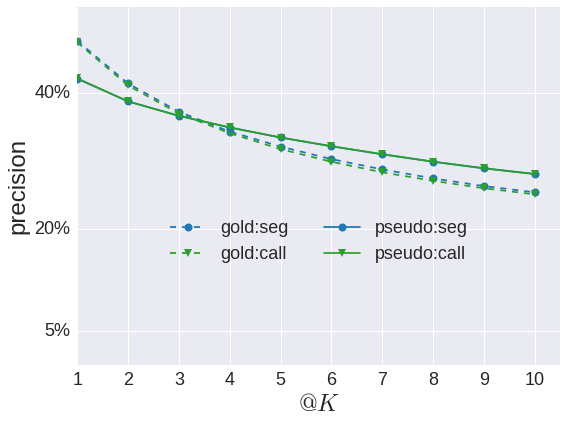

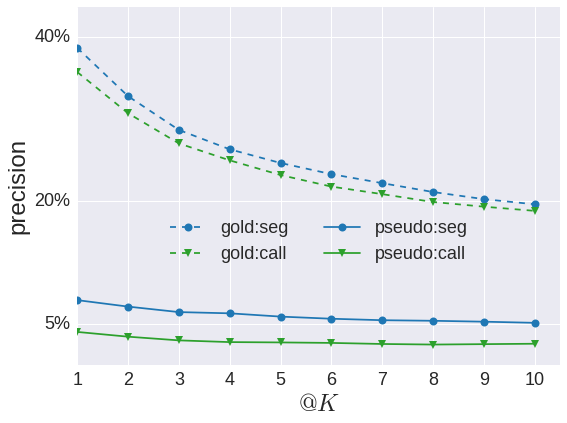

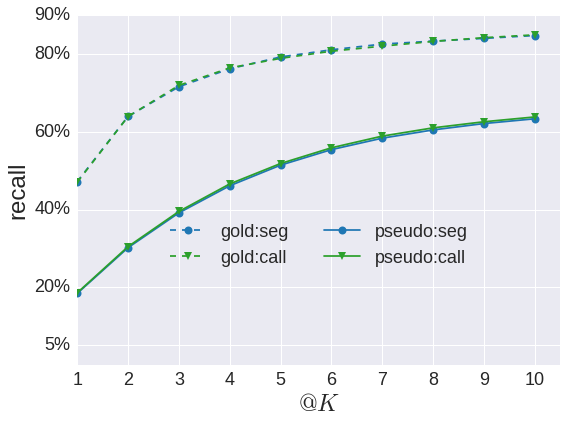

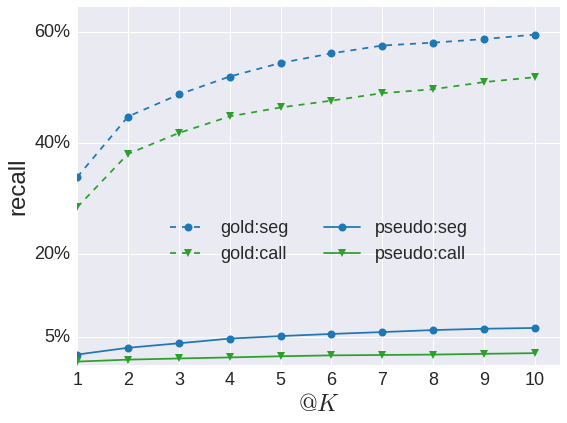

In [224]:
p_train = [gold_seg_train_prec, gold_call_train_prec, pseudo_seg_train_prec, pseudo_call_train_prec]
p_dev = [gold_seg_dev_prec, gold_call_dev_prec, pseudo_seg_dev_prec, pseudo_call_dev_prec]

r_train = [gold_seg_train_rec, gold_call_train_rec, pseudo_seg_train_rec, pseudo_call_train_rec]
r_dev = [gold_seg_dev_rec, gold_call_dev_rec, pseudo_seg_dev_rec, pseudo_call_dev_rec]

titles = ["precision", "precision", "recall", "recall"]
plot_names = ["p_train.png", "p_dev.png", "r_train.png", "r_dev.png"]
all_arrays = [p_train, p_dev, r_train, r_dev]
for i, data_array in enumerate(all_arrays):
    plot_eacl_results(data_array, plotname=plot_names[i], title=titles[i])